In [2]:
import numpy as np

DATA_DIR = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/'
GRAPH_PATH = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/'
SAMPLE_SIZE = -1 # -1 если использовать все даннные
DEPTH_RANGE = range(1, 20, 2)
KNN_NEIGHBORS_RANGE = range(1, 20, 2)
SVM_MAX_ITER_RANGE = range(10, 100, 10)
SVM_ALPHA_RANGE = np.fromfunction(lambda i: 0.0000001 * pow(10, i), (7,), dtype=float)

FEATURES = [
    'userAgentIsBot',
    'userAgentIsMobile',
    'userAgentIsTablet',
    'userAgentIsTouchCapable',
    'userAgentIsPC',
    'userAgentOSFamily',
    'userAgentOSVersion0',
    'userAgentOSVersion1',
    'userAgentOSVersion2',
    'userAgentBrowserFamily',
    'userAgentBrowserVersion0',
    'userAgentBrowserVersion1',
    'userAgentBrowserVersion2',
    'userAgentDeviceFamily',
    'userAgentDeviceBrand',
    'userAgentDeviceModel',
    'from',
    'to',
    'url',
    'requestType',
    'operation'
]

In [3]:
!pip install pyarrow
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import user_agents
%matplotlib inline
from matplotlib import pyplot as plt
pd.set_option("display.precision", 2)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
http = pq.read_table(DATA_DIR + 'botsHTTPRequests-20180217_1718_parsedUA.parquet', columns=FEATURES ).to_pandas().head(SAMPLE_SIZE)
target = pq.read_table(DATA_DIR + 'botsHTTPRequests-20180217_1718_parsedUA.parquet', columns=['isBot'] ).to_pandas().head(SAMPLE_SIZE)

In [4]:
# [http['userAgentOSFamily'].unique().shape,
# http['userAgentDeviceFamily'].unique().shape,
# http['userAgentDeviceBrand'].unique().shape,
# http['userAgentDeviceModel'].unique().shape,
# http['userAgentBrowserFamily'].unique().shape,
# http['from'].unique().shape,
# http['to'].unique().shape,
# http['url'].unique().shape,
# http['requestType'].unique().shape,
# http['operation'].unique().shape]

In [5]:
def hash_trick(x, n):
    return hash(x) % n

In [6]:
http['userAgentOSFamily'] = http['userAgentOSFamily'].apply(hash_trick, args=(10000,))
http['userAgentDeviceFamily'] = http['userAgentDeviceFamily'].apply(hash_trick, args=(10000,))
http['userAgentDeviceBrand'] = http['userAgentDeviceBrand'].apply(hash_trick, args=(10000,))
http['userAgentDeviceModel'] = http['userAgentDeviceModel'].apply(hash_trick, args=(10000,))
http['userAgentBrowserFamily'] = http['userAgentBrowserFamily'].apply(hash_trick, args=(10000,))
http['from'] = http['from'].apply(hash_trick, args=(10000,))
http['to'] = http['to'].apply(hash_trick, args=(10000,))
http['url'] = http['url'].apply(hash_trick, args=(10000000,))
http['requestType'] = http['requestType'].apply(hash_trick, args=(10000,))
http['operation'] = http['operation'].apply(hash_trick, args=(10000,))
http['userAgentOSVersion0'] = pd.to_numeric(http['userAgentOSVersion0'], 'coerce').fillna(0).astype(int)
http['userAgentOSVersion1'] = pd.to_numeric(http['userAgentOSVersion1'], 'coerce').fillna(0).astype(int)
http['userAgentOSVersion2'] = pd.to_numeric(http['userAgentOSVersion2'], 'coerce').fillna(0).astype(int)
http['userAgentBrowserVersion0'] = pd.to_numeric(http['userAgentBrowserVersion0'], 'coerce').fillna(0).astype(int)
http['userAgentBrowserVersion1'] = pd.to_numeric(http['userAgentBrowserVersion1'], 'coerce').fillna(0).astype(int)
http['userAgentBrowserVersion2'] = pd.to_numeric(http['userAgentBrowserVersion2'], 'coerce').fillna(0).astype(int)

In [7]:
# [http['userAgentOSFamily'].unique().shape,
# http['userAgentDeviceFamily'].unique().shape,
# http['userAgentDeviceBrand'].unique().shape,
# http['userAgentDeviceModel'].unique().shape,
# http['userAgentBrowserFamily'].unique().shape,
# http['from'].unique().shape,
# http['to'].unique().shape,
# http['url'].unique().shape,
# http['requestType'].unique().shape,
# http['operation'].unique().shape]

In [7]:
X = OneHotEncoder().fit_transform(http)
y = target['isBot']

In [8]:
rows, feats = X.shape

In [9]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

tree = DecisionTreeClassifier(random_state=17)
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
svm = SGDClassifier(random_state=17)

In [11]:
tree_params = {'max_depth': DEPTH_RANGE,'max_features': range(1, feats)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
tree_grid.fit(X_train, y_train)
tree_grid.best_params_, tree_grid.best_score_

Fitting 5 folds for each of 12900 candidates, totalling 64500 fits


/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/pyt

/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/pyt

/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/pyt

/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/pyt

/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 9760 tasks      | elapsed:   34.1s
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pred

({'max_depth': 19, 'max_features': 639}, 0.8828223608726551)

In [12]:
print(classification_report(y_holdout, tree_grid.predict(X_holdout), target_names = ['users', 'bots']))

             precision    recall  f1-score   support

      users       0.92      0.83      0.87      1475
       bots       0.85      0.93      0.89      1525

avg / total       0.88      0.88      0.88      3000



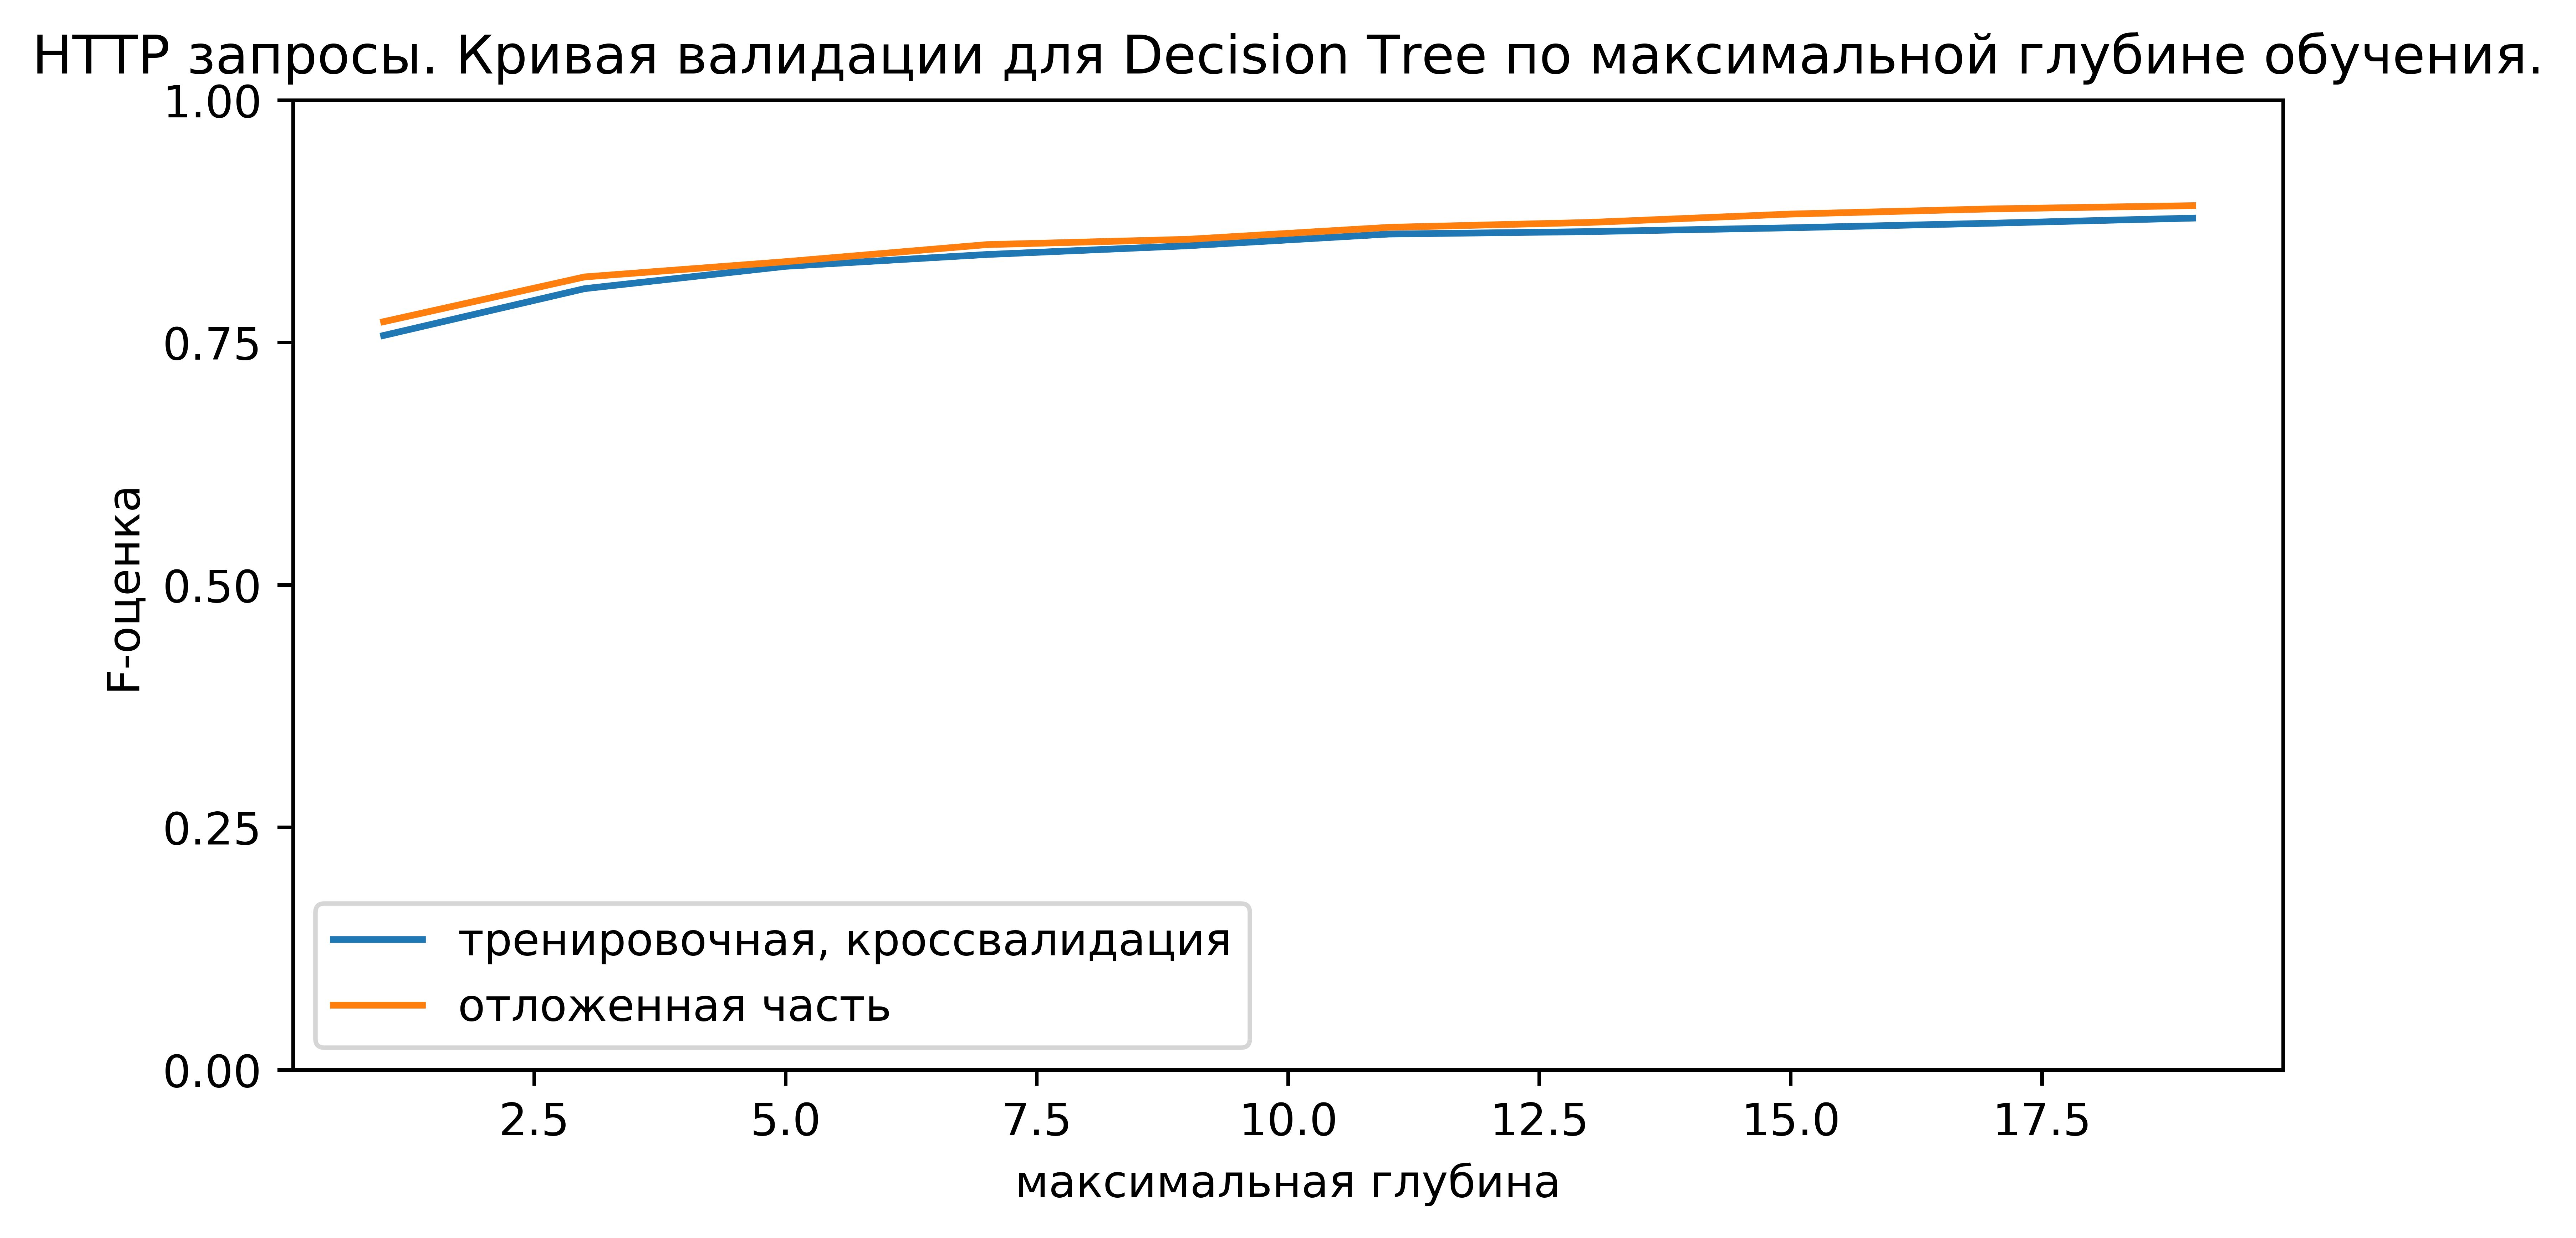

In [13]:
cv_scores, holdout_scores = [], []
max_depth = DEPTH_RANGE

for k in max_depth:

    tree = DecisionTreeClassifier(random_state=17, max_depth=k)
    cv_scores.append(np.mean(cross_val_score(tree, X_train, y_train, cv=5, scoring='f1')))
    tree.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, tree.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('максимальная глубина')
plt.plot(max_depth, cv_scores, label='тренировочная, кроссвалидация')
plt.plot(max_depth, holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для Decision Tree по максимальной глубине обучения.')
plt.savefig(GRAPH_PATH + 'tree.png', dpi=900)
plt.legend();

In [14]:
knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_RANGE}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fbf96f47d20, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/nsuprotivniy/anaconda3/lib/python3.6/site-...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/nsupro.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fbf96f47d20, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/nsuprotivniy/anaconda3/lib/python3.6/site-...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/nsupro.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 28, 15, 46, 58, 384374, tzinfo=tzutc()), 'msg_id': '3d95442f1ec84b2f9d21921b3cbafada', 'msg_type': 'execute_request', 'session': '7888d6ed020940e28f971b6db69bdbd1', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3d95442f1ec84b2f9d21921b3cbafada', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'7888d6ed020940e28f971b6db69bdbd1']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 28, 15, 46, 58, 384374, tzinfo=tzutc()), 'msg_id': '3d95442f1ec84b2f9d21921b3cbafada', 'msg_type': 'execute_request', 'session': '7888d6ed020940e28f971b6db69bdbd1', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3d95442f1ec84b2f9d21921b3cbafada', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'7888d6ed020940e28f971b6db69bdbd1'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 28, 15, 46, 58, 384374, tzinfo=tzutc()), 'msg_id': '3d95442f1ec84b2f9d21921b3cbafada', 'msg_type': 'execute_request', 'session': '7888d6ed020940e28f971b6db69bdbd1', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3d95442f1ec84b2f9d21921b3cbafada', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-14-c444d0ab7a8f>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fbf8944f1d0, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fbf43340810, file "<ipython-input-14-c444d0ab7a8f>", line 3>
        result = <ExecutionResult object at 7fbf8944f1d0, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fbf43340810, file "<ipython-input-14-c444d0ab7a8f>", line 3>, result=<ExecutionResult object at 7fbf8944f1d0, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fbf43340810, file "<ipython-input-14-c444d0ab7a8f>", line 3>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DATA_DIR': '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/', 'DEPTH_RANGE': range(1, 20, 2), 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'FEATURES': ['userAgentIsBot', 'userAgentIsMobile', 'userAgentIsTablet', 'userAgentIsTouchCapable', 'userAgentIsPC', 'userAgentOSFamily', 'userAgentOSVersion0', 'userAgentOSVersion1', 'userAgentOSVersion2', 'userAgentBrowserFamily', 'userAgentBrowserVersion0', 'userAgentBrowserVersion1', 'userAgentBrowserVersion2', 'userAgentDeviceFamily', 'userAgentDeviceBrand', 'userAgentDeviceModel', 'from', 'to', 'url', 'requestType', ...], 'GRAPH_PATH': '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/', 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import numpy as np\n\nDATA_DIR = '/home/nsuprotivn...,\n    'url',\n    'requestType',\n    'operation'\n]", "get_ipython().system('pip install pyarrow')\nimpo...iz\nfrom sklearn.preprocessing import MinMaxScaler", "http = pq.read_table(DATA_DIR + 'botsHTTPRequest...columns=['isBot'] ).to_pandas().head(SAMPLE_SIZE)", "# [http['userAgentOSFamily'].unique().shape,\n# h...ique().shape,\n# http['operation'].unique().shape]", 'def hash_trick(x, n):\n    return hash(x) % n', "http['userAgentOSFamily'] = http['userAgentOSFam...rowserVersion2'], 'coerce').fillna(0).astype(int)", "# [http['userAgentOSFamily'].unique().shape,\n# h...ique().shape,\n# http['operation'].unique().shape]", 'X = OneHotEncoder().fit_transform(http)\ny = target', 'rows, feats = X.shape', 'X_train, X_holdout, y_train, y_holdout = train_t...om_state=17)\nsvm = SGDClassifier(random_state=17)', "tree_params = {'max_depth': DEPTH_RANGE,'max_fea...in)\ntree_grid.best_params_, tree_grid.best_score_", "print(classification_report(y_holdout, tree_grid...ct(X_holdout), target_names = ['users', 'bots']))", "cv_scores, holdout_scores = [], []\nmax_depth = D...g(GRAPH_PATH + 'tree.png', dpi=900)\nplt.legend();", "knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_"], 'KNN_NEIGHBORS_RANGE': range(1, 20, 2), 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DATA_DIR': '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/', 'DEPTH_RANGE': range(1, 20, 2), 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'FEATURES': ['userAgentIsBot', 'userAgentIsMobile', 'userAgentIsTablet', 'userAgentIsTouchCapable', 'userAgentIsPC', 'userAgentOSFamily', 'userAgentOSVersion0', 'userAgentOSVersion1', 'userAgentOSVersion2', 'userAgentBrowserFamily', 'userAgentBrowserVersion0', 'userAgentBrowserVersion1', 'userAgentBrowserVersion2', 'userAgentDeviceFamily', 'userAgentDeviceBrand', 'userAgentDeviceModel', 'from', 'to', 'url', 'requestType', ...], 'GRAPH_PATH': '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/', 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import numpy as np\n\nDATA_DIR = '/home/nsuprotivn...,\n    'url',\n    'requestType',\n    'operation'\n]", "get_ipython().system('pip install pyarrow')\nimpo...iz\nfrom sklearn.preprocessing import MinMaxScaler", "http = pq.read_table(DATA_DIR + 'botsHTTPRequest...columns=['isBot'] ).to_pandas().head(SAMPLE_SIZE)", "# [http['userAgentOSFamily'].unique().shape,\n# h...ique().shape,\n# http['operation'].unique().shape]", 'def hash_trick(x, n):\n    return hash(x) % n', "http['userAgentOSFamily'] = http['userAgentOSFam...rowserVersion2'], 'coerce').fillna(0).astype(int)", "# [http['userAgentOSFamily'].unique().shape,\n# h...ique().shape,\n# http['operation'].unique().shape]", 'X = OneHotEncoder().fit_transform(http)\ny = target', 'rows, feats = X.shape', 'X_train, X_holdout, y_train, y_holdout = train_t...om_state=17)\nsvm = SGDClassifier(random_state=17)', "tree_params = {'max_depth': DEPTH_RANGE,'max_fea...in)\ntree_grid.best_params_, tree_grid.best_score_", "print(classification_report(y_holdout, tree_grid...ct(X_holdout), target_names = ['users', 'bots']))", "cv_scores, holdout_scores = [], []\nmax_depth = D...g(GRAPH_PATH + 'tree.png', dpi=900)\nplt.legend();", "knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_...rain)\nknn_grid.best_params_, knn_grid.best_score_"], 'KNN_NEIGHBORS_RANGE': range(1, 20, 2), 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/nsuprotivniy/Documents/Работа/OKru/Antispam/pandas analysis/<ipython-input-14-c444d0ab7a8f> in <module>()
      1 knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_RANGE}
      2 knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
----> 3 knn_grid.fit(X_train, y_train)
      4 knn_grid.best_params_, knn_grid.best_score_

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e..._score='warn',
       scoring='f1', verbose=True), X=<7000x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
3796      1
3599      0
7321      1
...
406       0
2191      0

[7000 rows x 1 columns], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X = <7000x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y =       isBot
3796      1
3599      0
7321      1
...
406       0
2191      0

[7000 rows x 1 columns]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Apr 28 18:54:46 2018
PID: 28781            Python 3.6.4: /home/nsuprotivniy/anaconda3/bin/python
...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('scaler', Sta...eighbors=1, p=2,
           weights='uniform'))]), <7000x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>,       isBot
3796      1
3599      0
7321      1
...
406       0
2191      0

[7000 rows x 1 columns], {'score': make_scorer(f1_score)}, array([1399, 1400, 1401, ..., 6997, 6998, 6999]), array([   0,    1,    2, ..., 1397, 1398, 1402]), True, {'knn__n_neighbors': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('scaler', Sta...eighbors=1, p=2,
           weights='uniform'))]), <7000x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>,       isBot
3796      1
3599      0
7321      1
...
406       0
2191      0

[7000 rows x 1 columns], {'score': make_scorer(f1_score)}, array([1399, 1400, 1401, ..., 6997, 6998, 6999]), array([   0,    1,    2, ..., 1397, 1398, 1402]), True, {'knn__n_neighbors': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('scaler', Sta...eighbors=1, p=2,
           weights='uniform'))]), X=<7000x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
3796      1
3599      0
7321      1
...
406       0
2191      0

[7000 rows x 1 columns], scorer={'score': make_scorer(f1_score)}, train=array([1399, 1400, 1401, ..., 6997, 6998, 6999]), test=array([   0,    1,    2, ..., 1397, 1398, 1402]), verbose=True, parameters={'knn__n_neighbors': 1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...ighbors=1, p=2,
           weights='uniform'))])>
        X_train = <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y_train =       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('scaler', Sta...eighbors=1, p=2,
           weights='uniform'))]), X=<5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns], **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N...ighbors=1, p=2,
           weights='uniform'))])>
        X = <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y =       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns]
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('scaler', Sta...eighbors=1, p=2,
           weights='uniform'))]), X=<5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns], **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'knn': {}, 'scaler': {}}
        name = 'scaler'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x7fbf5970a400>), *args=(StandardScaler(copy=True, with_mean=True, with_std=True), None, <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>,       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns]), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (StandardScaler(copy=True, with_mean=True, with_std=True), None, <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>,       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns])
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=StandardScaler(copy=True, with_mean=True, with_std=True), weight=None, X=<5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns], **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method TransformerMixin.fit_transform of ...Scaler(copy=True, with_mean=True, with_std=True)>
        X = <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y =       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns]
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/base.py in fit_transform(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=<5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns], **fit_params={})
    515         if y is None:
    516             # fit method of arity 1 (unsupervised transformation)
    517             return self.fit(X, **fit_params).transform(X)
    518         else:
    519             # fit method of arity 2 (supervised transformation)
--> 520             return self.fit(X, y, **fit_params).transform(X)
        self.fit = <bound method StandardScaler.fit of StandardScaler(copy=True, with_mean=True, with_std=True)>
        X = <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y =       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns]
        fit_params.transform = undefined
    521 
    522 
    523 class DensityMixin(object):
    524     """Mixin class for all density estimators in scikit-learn."""

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py in fit(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=<5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns])
    585         y : Passthrough for ``Pipeline`` compatibility.
    586         """
    587 
    588         # Reset internal state before fitting
    589         self._reset()
--> 590         return self.partial_fit(X, y)
        self.partial_fit = <bound method StandardScaler.partial_fit of Stan...Scaler(copy=True, with_mean=True, with_std=True)>
        X = <5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>
        y =       isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns]
    591 
    592     def partial_fit(self, X, y=None):
    593         """Online computation of mean and std on X for later scaling.
    594         All of X is processed as a single batch. This is intended for cases

...........................................................................
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py in partial_fit(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=<5600x1291 sparse matrix of type '<class 'numpy.... stored elements in Compressed Sparse Row format>, y=      isBot
4284      1
7328      1
4357      1
...
406       0
2191      0

[5600 rows x 1 columns])
    616         # See incr_mean_variance_axis and _incremental_mean_variance_axis
    617 
    618         if sparse.issparse(X):
    619             if self.with_mean:
    620                 raise ValueError(
--> 621                     "Cannot center sparse matrices: pass `with_mean=False` "
    622                     "instead. See docstring for motivation and alternatives.")
    623             if self.with_std:
    624                 # First pass
    625                 if not hasattr(self, 'n_samples_seen_'):

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.
___________________________________________________________________________

In [ ]:
print(classification_report(y_holdout, knn_grid.predict(X_holdout), target_names = ['users', 'bots']))

In [ ]:
cv_scores, holdout_scores = [], []
n_neighb = KNN_NEIGHBORS_RANGE

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')))
    knn.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, knn.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('количество соседей')
plt.plot(n_neighb, cv_scores, label='тренировочная, кроссвалидация')
plt.plot(n_neighb, holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для KNN по количеству соседей.')
plt.savefig(GRAPH_PATH + 'knn.png', dpi=900)
plt.legend();

In [ ]:
forest_params = {'max_depth': DEPTH_RANGE,'max_features': range(1,feats)}
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
forest_grid.fit(X_train, y_train)
forest_grid.best_params_, forest_grid.best_score_ 

In [ ]:
print(classification_report(y_holdout, forest_grid.predict(X_holdout), target_names = ['users', 'bots']))

In [ ]:
imp = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17,
                             max_features = forest_grid.best_params_['max_features'],
                             max_depth = forest_grid.best_params_['max_depth'],  
                            ).fit(X_train, y_train).feature_importances_

pd.options.display.float_format = '{:,.3f}'.format
pd.DataFrame(list(zip(FEATURES, imp*100)), columns=['fetures', 'importance'])

In [ ]:
cv_scores, holdout_scores = [], []
max_depth = DEPTH_RANGE

for k  in max_depth:
    forest = RandomForestClassifier(n_estimators=100, 
                                max_depth = k,
                                max_features = forest_grid.best_params_['max_features'],
                                n_jobs=-1, 
                                random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=5, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('максимальная глубина')
plt.plot(max_depth, cv_scores, label='тренировочная, кроссвалидация')
plt.plot(max_depth, holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для Random Forest по максимальной глубине обучения.')
plt.savefig(GRAPH_PATH + 'forest_maxdepth.png', dpi=900)
plt.legend();

In [ ]:
cv_scores, holdout_scores = [], []
max_features = range(1, feats)

for k  in max_features:
    forest = RandomForestClassifier(n_estimators=100, 
                                    max_depth = forest_grid.best_params_['max_depth'],  
                                    max_features = k,
                                    n_jobs=-1, 
                                    random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=5, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('максимальное количество фичей')
plt.plot(max_features, cv_scores, label='тренировочная, кроссвалидация')
plt.plot(max_features, holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для Random Forest по количеству фичей.')
plt.savefig(GRAPH_PATH + 'forest_maxfeats.png', dpi=900)
plt.legend();

In [ ]:
cv_scores, holdout_scores = [], []
split = np.arange(0.1, 0.8, 0.1)

for i in split:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=i, random_state=17)
    forest = RandomForestClassifier(n_estimators=5, 
                                    max_depth = 19,  
                                    max_features = 15,
                                    n_jobs=-1, 
                                    random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=2, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('размер отложенной части')
plt.plot(split * X.shape[0], cv_scores, label='тренировочная, кроссвалидация')
plt.plot(split * X.shape[0], holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для Random Forest по размеру отложенной части.')
plt.savefig(GRAPH_PATH + 'forest_testsplit_2.png', dpi=900)
plt.legend();

In [10]:
svm_params = {'alpha': (0.1, 0.01, 0.001, 0.00001, 0.0000001),
              'max_iter': (5, 10, 50, 80, 500, 1000)}
svm_grid = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
svm_grid.fit(X_train, y_train)
svm_grid.best_params_, svm_grid.best_score_ 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 43.8min finished


({'alpha': 1e-07, 'max_iter': 1000}, 0.6771124407886907)

In [ ]:
print(classification_report(y_holdout, svm_grid.predict(X_holdout), target_names = ['users', 'bots']))

             precision    recall  f1-score   support

      users       0.99      1.00      0.99    303120
       bots       0.94      0.53      0.68      6216

avg / total       0.99      0.99      0.99    309336



In [ ]:
cv_scores, holdout_scores = [], []
svm_max_iter_range = SVM_MAX_ITER_RANGE

for i in svm_max_iter_range:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=i, random_state=17)
    svm = SGDClassifier(random_state=17, max_iter=i,  alpha=svm_grid.best_params_['alpha'])
    cv_scores.append(np.mean(cross_val_score(svm, X_train, y_train, cv=5, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('максимальное количество итераций')
plt.plot(svm_max_iter_range, cv_scores, label='тренировочная, кроссвалидация')
plt.plot(svm_max_iter_range, holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для SVM по максимальной итерации.')
plt.savefig(GRAPH_PATH + 'svm_max_iter.png', dpi=900)
plt.legend();

In [ ]:
cv_scores, holdout_scores = [], []
svm_alpha_range = SVM_ALPHA_RANGE

for i in svm_alpha_range:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=i, random_state=17)
    svm = SGDClassifier(random_state=17, max_iter=svm_grid.best_params_['max_iter'],  alpha=i)
    cv_scores.append(np.mean(cross_val_score(svm, X_train, y_train, cv=5, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-оценка')
plt.xlabel('альфа')
plt.plot(svm_alpha_range, cv_scores, label='тренировочная, кроссвалидация')
plt.plot(svm_alpha_range, holdout_scores, label='отложенная часть')
plt.title('HTTP запросы. Кривая валидации для SVM по параметру alpha.')
plt.savefig(GRAPH_PATH + 'svm_alpha.png', dpi=900)
plt.legend();

In [ ]:
cv_scores, holdout_scores = [], []
split = np.arange(0.1, 1, 0.1)
svm = SGDClassifier(random_state=17,
                    max_iter=svm_grid.best_params_['max_iter'],  
                    alpha=svm_grid.best_params_['alpha'])
svm.fit(X_train, y_train)

for i in split:
    train_test_split_bound = int(X_holdout.shape[0] * i)
    X_split = X_holdout[:train_test_split_bound]
    y_split = y_holdout[:train_test_split_bound]
    holdout_scores.append(f1_score(y_split, svm.predict(X_split)))
    

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,100)
plt.yticks(np.linspace(0,100,5,endpoint=True))
plt.ylabel('F-оценка, %')
plt.xlabel('размер тестовой выборки')
plt.plot(split * X_holdout.shape[0], np.multiply(holdout_scores, 100))
plt.title('Классификация HTTP запросам.\nF-оценка для размера тренировочной выборки')
plt.savefig(GRAPH_PATH + 'http_svm_gcd_holdout.png', dpi=900)
plt.legend();